In [1]:
# import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
#from tensorflow.keras.utils import to_categorical
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support, accuracy_score)
# set options
pd.options.display.float_format = '{:.4f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
plt.close('all')

In [2]:
# disable chained assignments
#pd.options.mode.chained_assignment = None 

In [3]:
d=dt.datetime.now()
#dirbase=d.strftime('%Y%m%d%H')
tstr=d.strftime('%Y%m%d')
dirbase = "report/" + tstr +"/"
print(dirbase)
!mkdir -p $dirbase

report/20201201/


use the same way as boeing model
1. filter only FE direct users
2. filter only clicks before enrollment time
3. dedup, one user one record per day
4. handle missing data
5. build model
6. create profile to evaluate the model




# read data from files

In [4]:

date_col = ['event_ts','first_enrollment_date','enrollment_date']
df_data = pd.read_csv('data/wpi-alert-data-20201023-1y.csv', sep='|', parse_dates=date_col)
df_zip = pd.read_csv('data/zipcode.csv', sep=',')
df_zip['zipcode'] = df_zip['ZipCode']


/Users/hli/.env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df_data['enrolled'] = 0
df_data.loc[df_data.enrollment_date.notnull(), 'enrolled'] = 1
df_data['dayofweek'] = df_data.event_ts.dt.dayofweek
#df_data['hour'] = df_data.event_ts.dt.hour
df_data['datenum'] = df_data['event_ts'].dt.strftime('%Y%M%d')

In [6]:
def convertToZip(x):
    if x is None:
        return 0
    xstr = str(x).strip()
    try:
        return int(xstr[0:5])
    except ValueError:
        return 0
# convert the long zip code to 5 digitals
df_data['zipcode'] = df_data.zip.apply(convertToZip)    
df = pd.merge(df_data, df_zip, on='zipcode', how='left')

In [7]:
df.shape, df.columns

((2467385, 99),
 Index(['usernum', 'event_ts', 'wpi_alert', 'placement', 'event', 'rknum',
        'sponsornum', 'participant_typenum', 'gender', 'obfuscated_dob',
        'asset_balance', 'income', 'participant_typenum_after',
        'first_enrollment_date', 'enrollment_date', 'cancellation_date', 'zip',
        'industrynum', 'retirement_age', 'participant_age',
        'has_personalized_flag', 'outside_accounts_count', 'inbound_w1',
        'inbound_w2', 'inbound_w3', 'inbound_w4', 'inbound_w5', 'inbound_w6',
        'inbound_w7', 'inbound_w8', 'inbound_w9', 'outbound_w1', 'outbound_w2',
        'outbound_w3', 'outbound_w4', 'outbound_w5', 'outbound_w6',
        'outbound_w7', 'outbound_w8', 'outbound_w9', 'sent_w1', 'sent_w2',
        'sent_w3', 'sent_w4', 'sent_w5', 'sent_w6', 'sent_w7', 'sent_w8',
        'sent_w9', 'opened_w1', 'opened_w2', 'opened_w3', 'opened_w4',
        'opened_w5', 'opened_w6', 'opened_w7', 'opened_w8', 'opened_w9',
        'click_w1', 'click_w2', 'click_w

In [8]:
#df.describe()

In [9]:
#remove clicks after enrollment time
df = df.loc[(df['enrollment_date'].isnull()) | (df['event_ts'] < df['enrollment_date'])]
df.shape, df.enrolled.describe()

((1700380, 99),
 count   1700380.0000
 mean          0.0354
 std           0.1849
 min           0.0000
 25%           0.0000
 50%           0.0000
 75%           0.0000
 max           1.0000
 Name: enrolled, dtype: float64)

In [10]:

#filter only FE direct users

df = df.loc[df['rknum'].isin([1,2,4,5,7,9,16,17,18,19])]
df.shape

(353770, 99)

In [11]:
df.enrolled.describe()

count   353770.0000
mean         0.0455
std          0.2084
min          0.0000
25%          0.0000
50%          0.0000
75%          0.0000
max          1.0000
Name: enrolled, dtype: float64

In [12]:
df.enrolled.describe()

count   353770.0000
mean         0.0455
std          0.2084
min          0.0000
25%          0.0000
50%          0.0000
75%          0.0000
max          1.0000
Name: enrolled, dtype: float64

In [13]:
#dedup, one user one record per day
#df['dates'] = df['event_ts'].dt.date
#df['rownum'] = df.sort_values(['event_ts'], ascending=[False]).groupby(['dates', 'usernum', 'enrollment_date']).cumcount()+1
#df = df.loc[df.rownum==1]

In [14]:
#dedup, one user one record per day
df = df.sort_values(['event_ts'], ascending=[False]).reset_index(drop=True)
df = df.drop_duplicates(subset=['usernum','datenum', 'enrolled'])
df.shape

(348997, 99)

In [15]:
df.enrolled.describe()

count   348997.0000
mean         0.0458
std          0.2090
min          0.0000
25%          0.0000
50%          0.0000
75%          0.0000
max          1.0000
Name: enrolled, dtype: float64

In [16]:
df.event_ts.min(), df.event_ts.max()

(Timestamp('2020-01-01 00:02:05'), Timestamp('2020-10-21 23:53:12'))

# Feature Engineering

In [17]:
df.columns

Index(['usernum', 'event_ts', 'wpi_alert', 'placement', 'event', 'rknum',
       'sponsornum', 'participant_typenum', 'gender', 'obfuscated_dob',
       'asset_balance', 'income', 'participant_typenum_after',
       'first_enrollment_date', 'enrollment_date', 'cancellation_date', 'zip',
       'industrynum', 'retirement_age', 'participant_age',
       'has_personalized_flag', 'outside_accounts_count', 'inbound_w1',
       'inbound_w2', 'inbound_w3', 'inbound_w4', 'inbound_w5', 'inbound_w6',
       'inbound_w7', 'inbound_w8', 'inbound_w9', 'outbound_w1', 'outbound_w2',
       'outbound_w3', 'outbound_w4', 'outbound_w5', 'outbound_w6',
       'outbound_w7', 'outbound_w8', 'outbound_w9', 'sent_w1', 'sent_w2',
       'sent_w3', 'sent_w4', 'sent_w5', 'sent_w6', 'sent_w7', 'sent_w8',
       'sent_w9', 'opened_w1', 'opened_w2', 'opened_w3', 'opened_w4',
       'opened_w5', 'opened_w6', 'opened_w7', 'opened_w8', 'opened_w9',
       'click_w1', 'click_w2', 'click_w3', 'click_w4', 'click_w5', 'c

In [ ]:
# add year to retire

In [ ]:
# import funcitons from python code to notebook
# %run path/run2.py

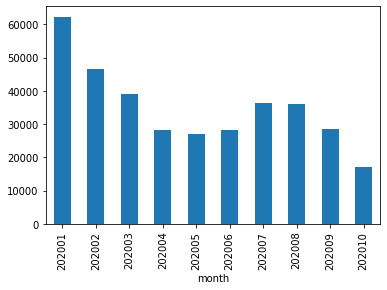

In [19]:
df['dayofweek'] = df.event_ts.dt.dayofweek
df['year'] = df.event_ts.dt.year
df['month'] = df['event_ts'].map(lambda x: 100*x.year + x.month)
df.groupby('month')['month'].count().plot(kind = 'bar')

In [20]:
df.isna().any()

usernum               False
event_ts              False
wpi_alert              True
placement              True
event                 False
                      ...  
NumberOfBusinesses     True
LocationID             True
Distance               True
year                  False
month                 False
Length: 101, dtype: bool

In [ ]:
cat_cols = ['rknum', 'sponsornum', 'gender_n']  
num_cols = ['asset', 'income',  'age', 'ret_age', 'has_personalized_flag', 'modified_ret_age_for_spouse_or_partner', 'outside_accounts_count', 
            'personalization_co_stock_level_count', 'personalization_oaccount_count', 'personalization_ret_age_count', 
            'personalization_risk_level_count', 'Distance','inbound_w1', 'inbound_w2','inbound_w3', 'inbound_w4', 
            'inbound_w5', 'inbound_w6', 'inbound_w7','inbound_w8', 'inbound_w9', 'outbound_w1', 'outbound_w2', 'outbound_w3','outbound_w4', 'outbound_w5', 
            'outbound_w6', 'outbound_w7','outbound_w8', 'outbound_w9', 'sent_w1', 'sent_w2', 'sent_w3','sent_w4', 'sent_w5', 'sent_w6', 'sent_w7', 'sent_w8', 
            'sent_w9','opened_w1', 'opened_w2', 'opened_w3', 'opened_w4', 'opened_w5','opened_w6', 'opened_w7', 'opened_w8', 'opened_w9', 'click_w1',
            'click_w2', 'click_w3', 'click_w4', 'click_w5', 'click_w6', 'click_w7','click_w8', 'click_w9', 'web_visits_w1', 'web_visits_w2','web_visits_w3', 
            'web_visits_w4', 'web_visits_w5', 'web_visits_w6','web_visits_w7', 'web_visits_w8', 'web_visits_w9', 'wpi_clicks_w1','wpi_clicks_w2', 
            'wpi_clicks_w3', 'wpi_clicks_w4', 'wpi_clicks_w5','wpi_clicks_w6', 'wpi_clicks_w7', 'wpi_clicks_w8', 'wpi_clicks_w9']

In [ ]:
import lightgbm
def lightgbm_training(X_train, Y_train, X_validate, Y_validate):
    start_ts = dt.datetime.now()
    train_data = lightgbm.Dataset(X_train, label=Y_train)
    validate_data = lightgbm.Dataset(X_validate, label=Y_validate)
    parameters = {
        'application': 'binary',
        'objective': 'binary',
        'metric': 'auc',
        'is_unbalance': 'true',
        'boosting': 'gbdt',
        'num_leaves': 17,
        'feature_fraction': 0.5,
        'bagging_fraction': 0.5,
        'bagging_freq': 5,
        'learning_rate': 0.05,
        'verbose': 0,
        'seed': 2,
        'boost_from_average': 'true'
    }

    lgbmodel = lightgbm.train(parameters,
                       train_data,
                       valid_sets=validate_data,
                       categorical_feature = cat_cols,
                       num_boost_round=5000,
                       early_stopping_rounds=500)
    print("Trainging takes {}".format(dt.datetime.now() - start_ts))
    return lgbmodel

In [ ]:
lgbmodel = lightgbm_training(X_train, Y_train, X_validate, Y_validate)

In [1]:
5+6

11

In [2]:
import time